In [6]:
!pip install transformers
import torch
import pandas as pd
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:
uploaded_file_path = "merged_data.csv"

In [21]:
df = pd.read_csv(uploaded_file_path)

input_data = df["Text"].tolist()
labels = df["Label"].tolist()

In [22]:
input_data = [str(sentence) for sentence in input_data]

In [23]:
train_texts, val_texts, train_labels, val_labels = train_test_split(input_data, labels, test_size=0.2, random_state=42)

In [24]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [26]:
train_tokenized = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
train_input_ids = train_tokenized["input_ids"]
train_attention_mask = train_tokenized["attention_mask"]
train_labels = torch.tensor(train_labels, dtype=torch.long)
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [27]:
val_tokenized = tokenizer(val_texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
val_input_ids = val_tokenized["input_ids"]
val_attention_mask = val_tokenized["attention_mask"]
val_labels = torch.tensor(val_labels, dtype=torch.long)
val_dataset = TensorDataset(val_input_ids, val_attention_mask, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False)

In [28]:
total_entries = df.shape[0]
print(f'Total entries in the dataset: {total_entries}')

Total entries in the dataset: 58619


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', config=config)
model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [31]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_epochs = 1

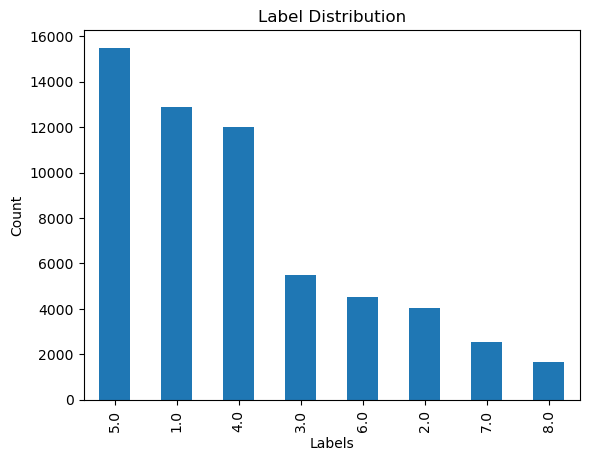

In [32]:
label_counts = df["Label"].value_counts()
label_counts.plot(kind='bar', xlabel='Labels', ylabel='Count', title='Label Distribution')
plt.show()

In [34]:
from tqdm import tqdm

In [35]:
for epoch in range(total_epochs):
    epoch_progress = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{total_epochs}', dynamic_ncols=True)
    
    for batch in epoch_progress:
        input_ids_batch, attention_mask_batch, labels_batch = [t.to(device) for t in batch]
        
        optimizer.zero_grad()
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch, labels=labels_batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        epoch_progress.set_postfix({'Loss': loss.item()}, refresh=True)
    
    epoch_progress.close()

Epoch 1/1:  22%|██▏       | 5230/23448 [10:20:28<36:01:21,  7.12s/it, Loss=0.00109] 


KeyboardInterrupt: 

In [ ]:
model.save_pretrained("C:/Users/kkysh/Downloads/ML KA MAAL/Doc Categorization Project/models/your_model_directory")
tokenizer.save_pretrained("C:/Users/kkysh/Downloads/ML KA MAAL/Doc Categorization Project/models/your_model_directory")

In [ ]:
model.eval()
all_predictions = []
all_labels = []

for batch in val_dataloader:
    input_ids_batch, attention_mask_batch, labels_batch = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = model(input_ids_batch, attention_mask=attention_mask_batch)
    
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    
    all_predictions.extend(predictions)
    all_labels.extend(labels_batch.cpu().numpy())

In [ ]:
accuracy = accuracy_score(all_labels, all_predictions)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')